<a href="https://colab.research.google.com/github/rajeshmore1/DataScience_Mentorship/blob/main/ML_26_Anomaly_Detection_Using_Isolation_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
A real-world dataset often contains anomalies or outlier data points. The cause of anomalies may be data corruption, experimental or human errors. The presence of anomalies may impact the performance of the model, hence to train a robust data science model, the dataset should be free from anomalies.

# What are Anomalies?
Anomalies are data points that stand out amongst other data points in the dataset and do not confirm the normal behavior in the data. These data points or observations deviate from the dataset’s normal behavioral patterns.

Anomaly detection is an unsupervised data processing technique to detect anomalies from the dataset. An anomaly can be broadly classified into different categories:

* Outliers: Short/small anomalous patterns that appear in a non-systematic way in data collection.
* Change in Events: Systematic or sudden change from the previous normal behavior.
* Drifts: Slow, undirectional, long-term change in the data.

Anomalies detection are very useful to detect fraudulent transactions, disease detection, or handle any case studies with high-class imbalance. Anomalies detection techniques can be used to build more robust data science models.

# How to detect Anomalies?
Simple statistical techniques such as mean, median, quantiles can be used to detect univariate anomalies feature values in the dataset. Various data visualization and exploratory data analysis techniques can be also be used to detect anomalies.

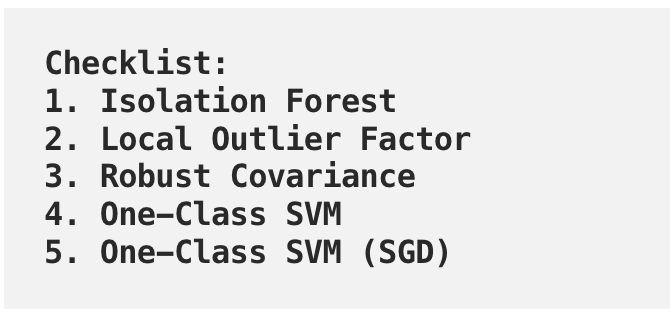

# “Why is anomaly detection so hard?”
Anomaly (or outlier) detection is the task of identifying data points that are “very strange” compared to the majority of observations.

This is useful in a range of applications, from fault detection to discovery of financial frauds, from finding health issues to identifying unsatisfied customers. Moreover, it can also be beneficial for machine learning pipelines, since it has been proven that removing outliers leads to an increase in model accuracy.

What makes anomaly detection so hard is that it is an unsupervised problem. In other words, we usually don’t have labels telling us which instances are actually “anomalies”. Or rather, even if we had labels, it would be very hard to frame anomaly detection as a supervised problem. In fact:

* anomalies are rare;
* anomalies are novel;
* anomalies are different from each other.

For all these reasons, supervised techniques typically make a bad fit with anomaly detection.

# What is so special about Isolation Forest
The traditional approach to anomaly detection was roughly:

1. Describe how “normal instances” look like (this usually involves cluster analysis).
2. Label all instances that don’t fit into those profiles as outliers.

The innovation introduced by Isolation Forest is that it starts directly from outliers rather than from normal observations.

The core idea is that it should be very easy to “isolate” anomalies based on the caracteristics that make them unique.

Technically, this translates into the fact that, **if we fit a decision tree on all the observations, outliers should be found closer to the root of the tree than “normal” instances.**

What does it mean? Let’s make this clear with an example.

Suppose that we have a dataset containing data about all the 7,932,843,214 humans alive right now. We have as many variables as we want: age, net worth, place of residence, job title…

What are the outliers in such a dataset? Keep in mind that outliers are not necessarily wrong data: they are just data points that are very different from the rest of the population. In this example, Jeff Bezos is for sure an outlier.

Now imagine that we could fit a decision tree such that each terminal leaf contains one and only one person. In other words, this tree is completely unpruned. If the assumption behind Isolation Forest is correct, then Jeff Bezos will be found closer to the tree root than, say, myself.

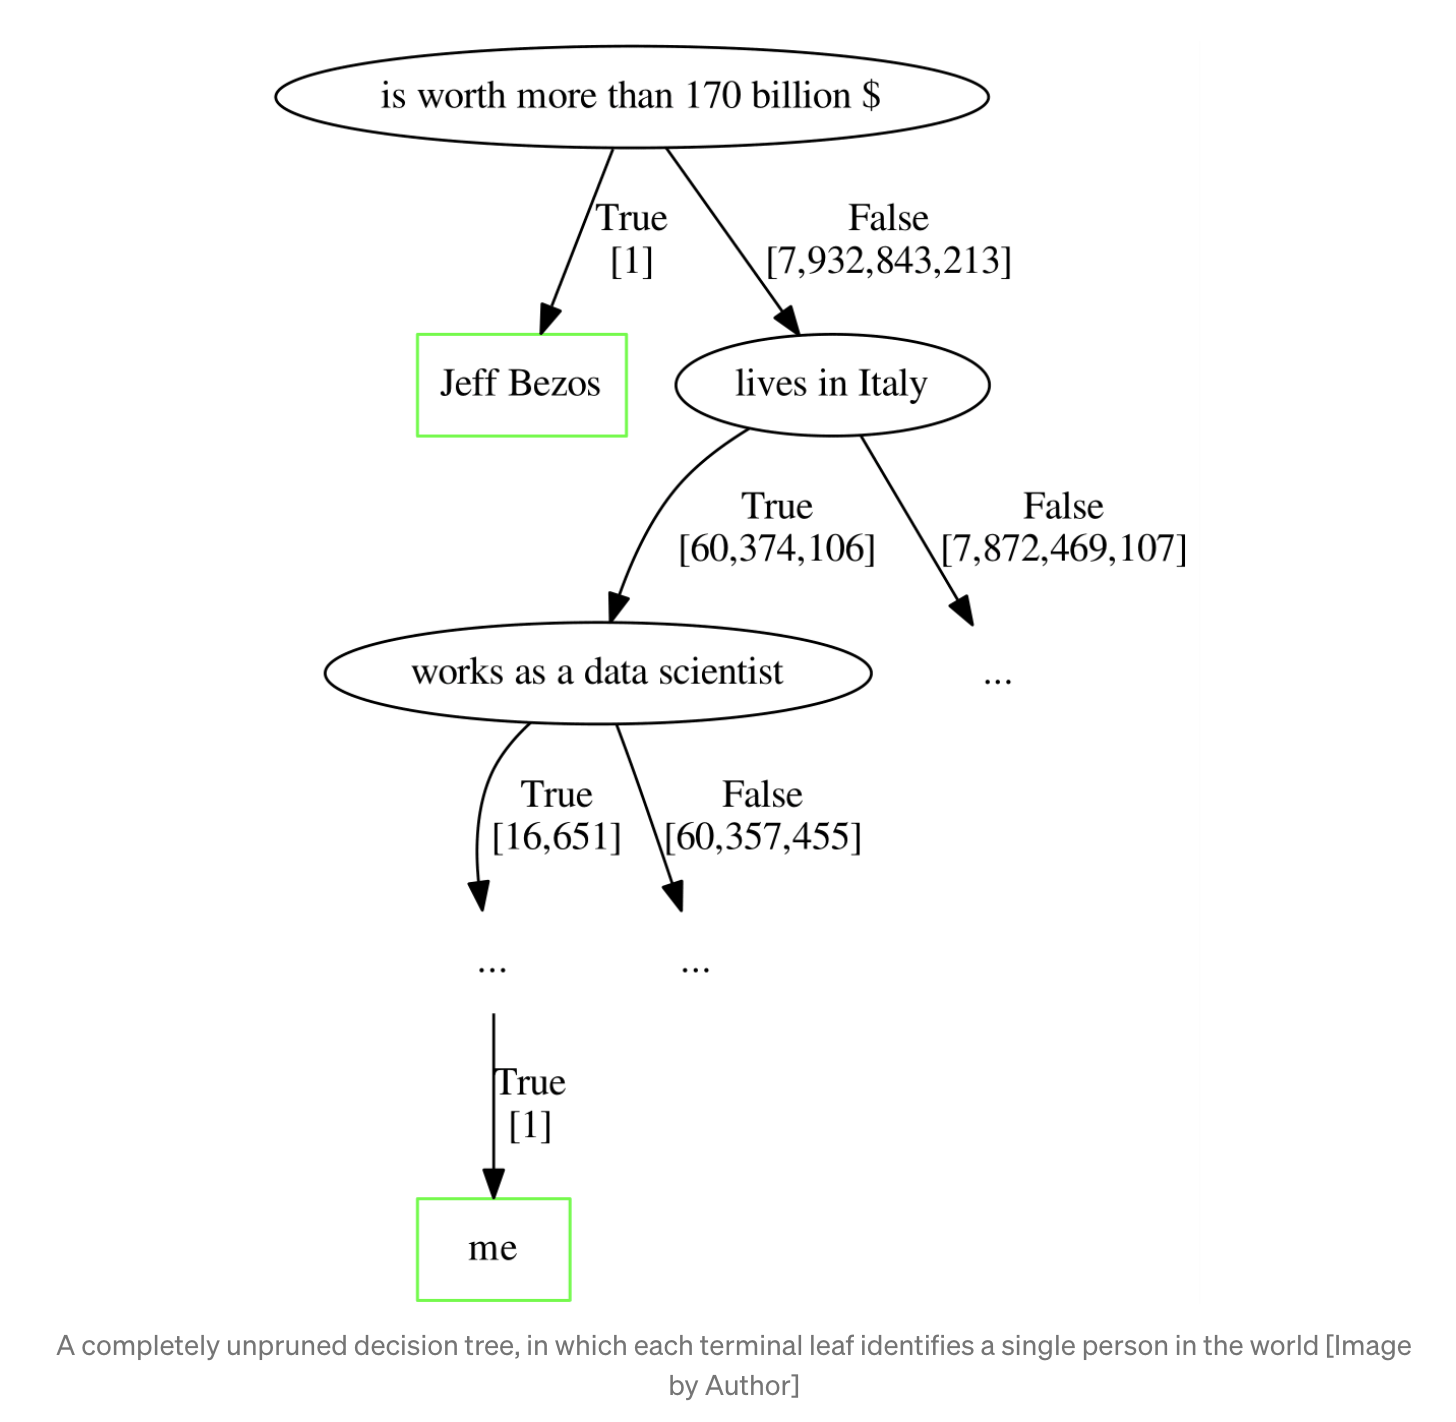

Being an outlier, Jeff Bezos is easier to isolate: it’s enough to ask “is he worth more than 170 billion $?” to retrieve him among almost 8 billion humans. On the other hand, since I am by far more ordinary than Jeff Bezos, you would probably need at least 10 True/False question to narrow down the search space until you find me.

## Looking under the hood
Now that we have seen the main intuition behind Isolation Forest, let’s try to understand the exact mechanics of the algorithm, with the aid of some simple data points.



In [1]:
import pandas as pd
df = pd.DataFrame({
    'x': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0],
    'y': [2.1, 2.4, 3.0, 2.6, 2.2, 2.8, 3.7]
}, index = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])

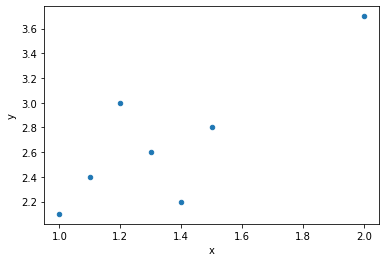

In [3]:
df.plot.scatter(x="x", y="y")

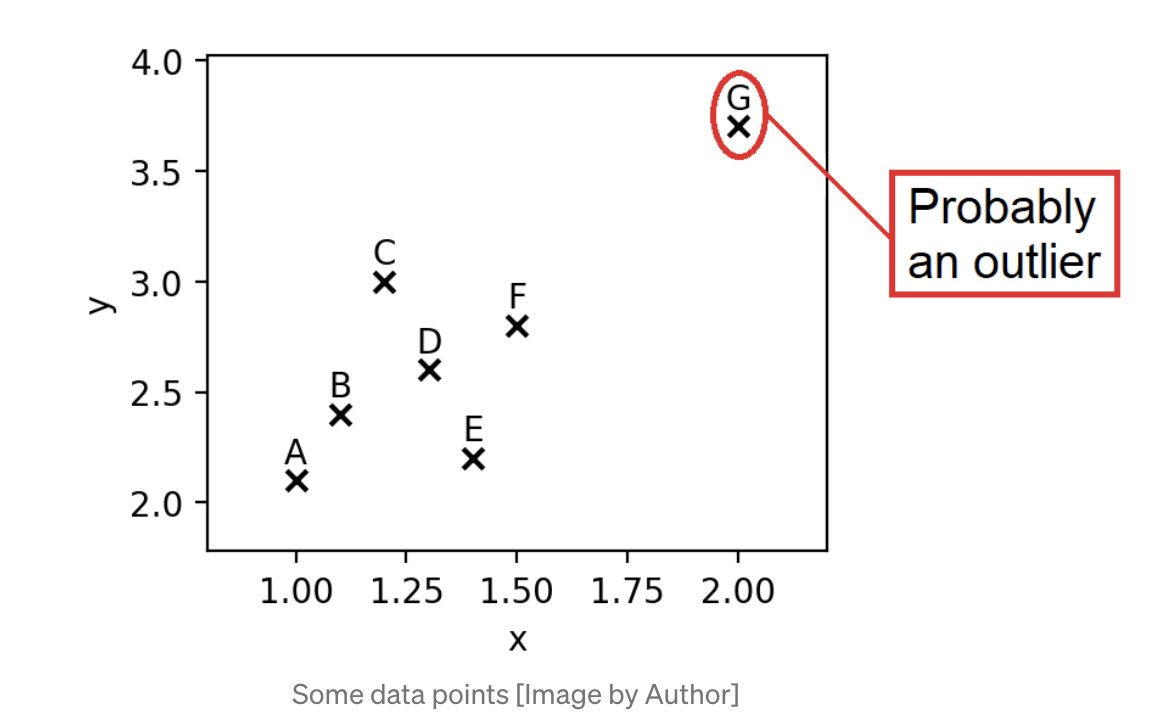

Items from A to F represent a quite compact cloud of points: they are “normal” data points. Compared to these instances, G is probably an outlier: it has anomalous values both for x and y.

Isolation Forest is based on trees, so let’s fit a tree on these data:



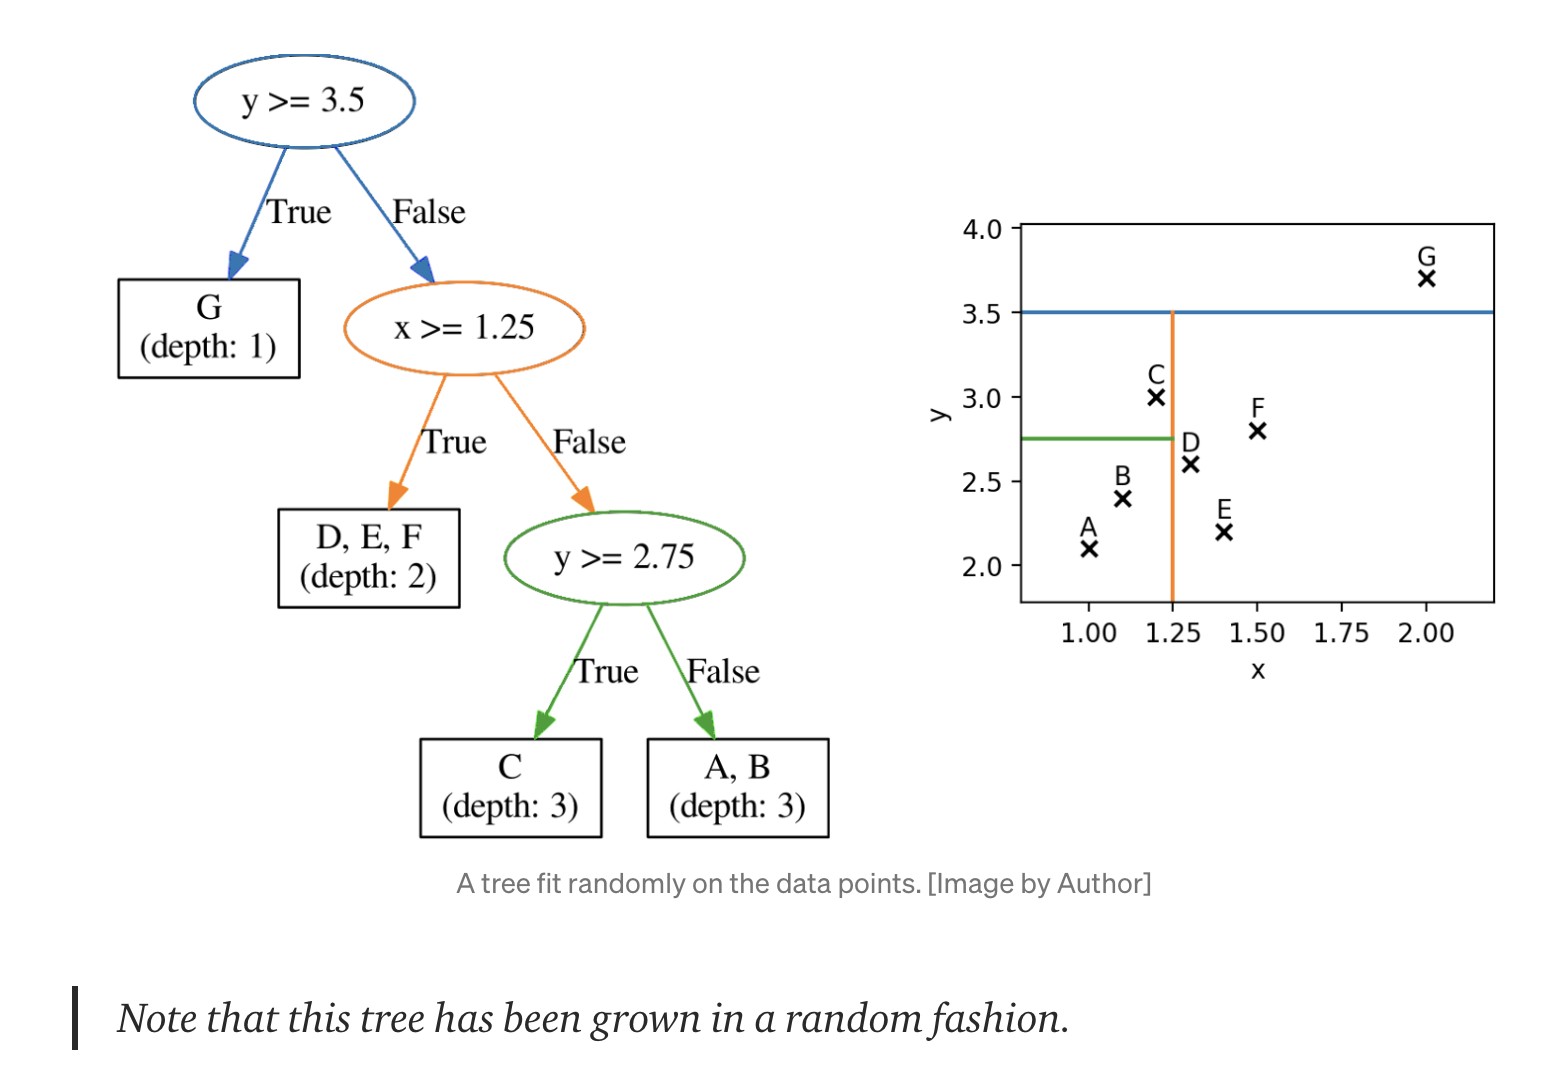

The most fundamental concept here is the depth of the leaf at which each element is found. For example, in this tree, the observation called G (our outlier) is at depth 1 (e.g. 1 level from the root node), whereas C is at depth 3.

**The idea behind Isolation Forest is that, on average, outliers will be closer to the root node (i.e. at a lower depth) than normal instances.**

As often in machine learning, the key is iteration. In fact, if we randomly fit many decision trees, and then take an average of the depth of each observation over the different trees, we find an “average depth” that represents an empirical measure of “outlierness”.



# Isolation Forest in Scikit-learn
Let’s see an example of usage through the Scikit-learn’s implementation.

In [4]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators = 100).fit(df)

If we take the first 9 trees from the forest (iforest.estimators_[:9]) and plot them, this is what we get:

In [5]:
iforest.estimators_[:9]

[ExtraTreeRegressor(max_depth=3, max_features=1, random_state=637945643),
 ExtraTreeRegressor(max_depth=3, max_features=1, random_state=1319570945),
 ExtraTreeRegressor(max_depth=3, max_features=1, random_state=1793684076),
 ExtraTreeRegressor(max_depth=3, max_features=1, random_state=1607948802),
 ExtraTreeRegressor(max_depth=3, max_features=1, random_state=770442289),
 ExtraTreeRegressor(max_depth=3, max_features=1, random_state=1941707084),
 ExtraTreeRegressor(max_depth=3, max_features=1, random_state=1920779213),
 ExtraTreeRegressor(max_depth=3, max_features=1, random_state=2064857511),
 ExtraTreeRegressor(max_depth=3, max_features=1, random_state=1402874007)]

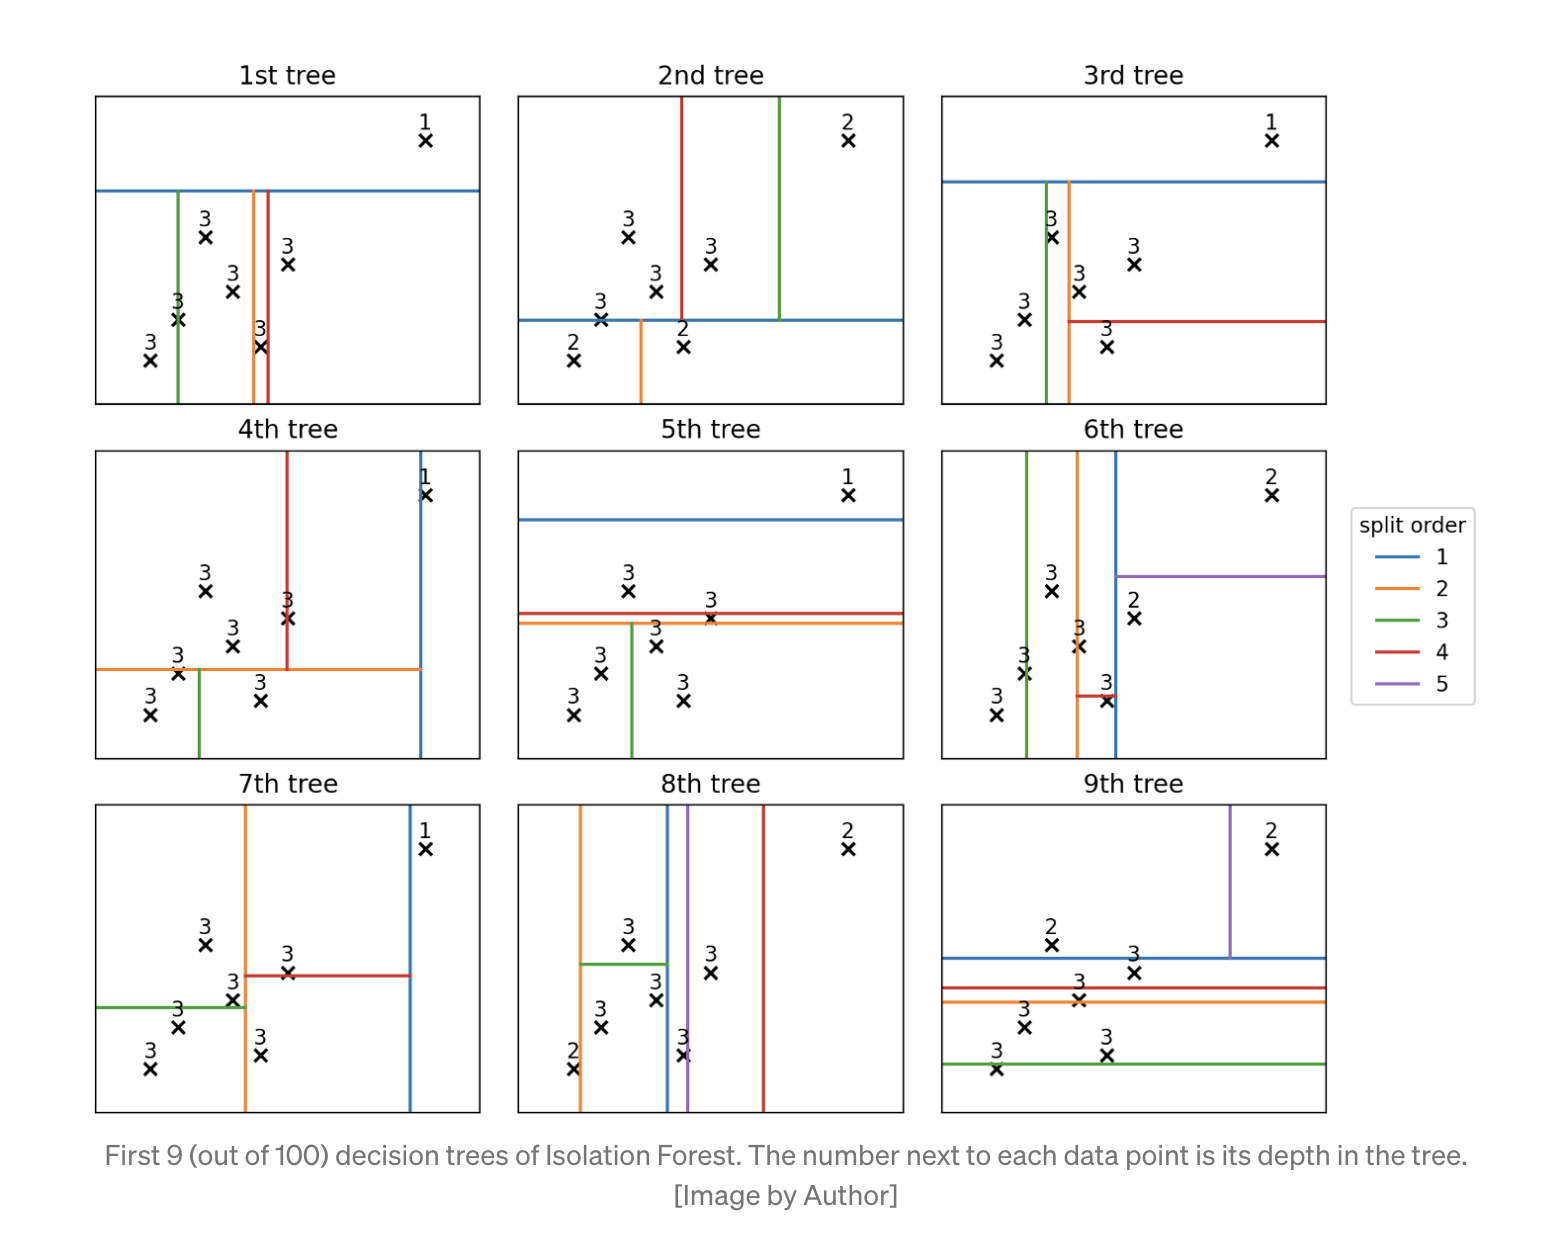

Taking a look at these first 9 trees, we can already see a pattern: G tends to be at a much lower depth (1.44 on average) than any other point. Indeed, the second point is A with an average depth of 2.78.

Conceptually, this is exactly how the algorithm works: a lower average depth means a higher likelihood of being an outlier.

However, in practice, we cannot use average depth, since the depth of a tree depends on the number of samples it has been fit on. For this reason, we need a formula that also take into account the total number of instances. This is the formula proposed in the paper:

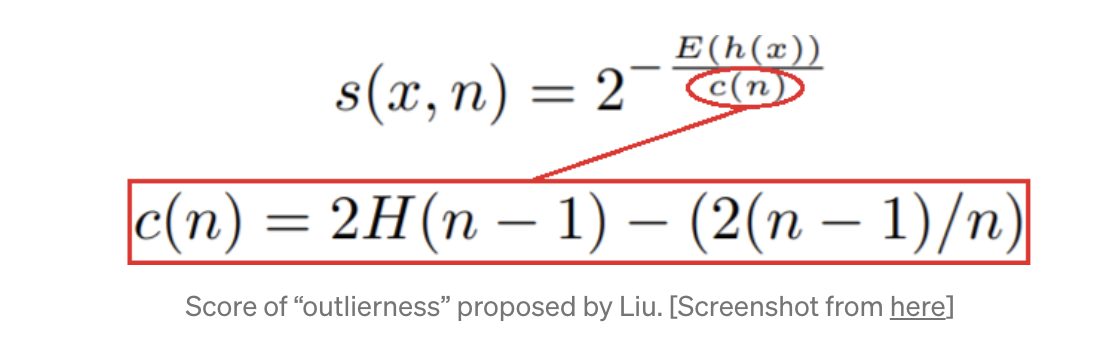

where n is the number of instances, h(x) is the depth at which the data point is found in a particular tree (E(h(x)) is its average over different trees), and H is the armonic number.

s(x, n) is a number between 0 and 1, where the higher the score the more likely it is an outlier.

Note: Scikit-learn’s implementation returns the opposite of the score defined above. So what said above is still valid, but with negative sign.

On our small dataset, the scores are given by:

In [6]:
scores = iforest.score_samples(df)


In [7]:
scores

array([-0.51850815, -0.44118087, -0.45794278, -0.41118216, -0.46330044,
       -0.44916252, -0.67229237])

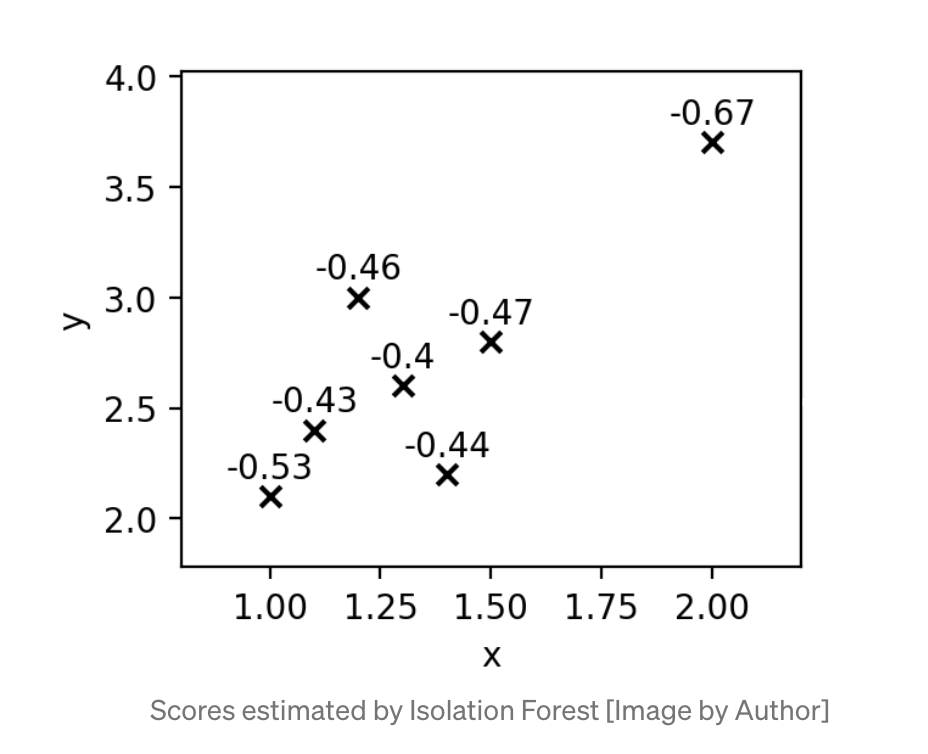

As we expected, G is more likely to be an outlier, since its score is lower than all the other scores.



# Example:

# Anomaly detection

Anomaly detection is the process of identifying unexpected items or events in data sets, which differ from the norm. And anomaly detection is often applied on unlabeled data which is known as unsupervised anomaly detection. 

Anomaly detection has two basic assumptions:
* Anomalies only occur very rarely in the data.
* Their features differ from the normal instances significantly.

## Univariate Anomaly Detection

Before we get to Multivariate anomaly detection, its necessary to work through a simple example of Univariate anomaly detection method in which we detect outliers from a distribution of values in a single feature space.

We are using a super store sales data set, and we are going to find patterns in Sales and Profit separately that do not conform to expected behavior. That is, spotting outliers for one variable at a time.

In [1]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import IsolationForest

from scipy import stats

In [ ]:
pip install --upgrade xlrd


In [2]:
df = pd.read_excel("/content/drive/MyDrive/My Mentorship/Superstore.xls")

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


### Sales Variable Analysis

In [4]:
df.Sales.describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

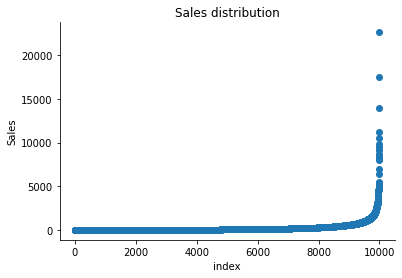

In [5]:
plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


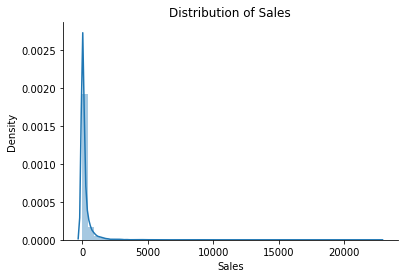

In [6]:
sns.distplot(df['Sales'])
plt.title("Distribution of Sales")
sns.despine()

In [7]:
print("Skewness: %f" % df['Sales'].skew())
print("Kurtosis: %f" % df['Sales'].kurt())

Skewness: 12.972752
Kurtosis: 305.311753


The Superstore’s sales distribution is far from a normal distribution, and it has a positive long thin tail, the mass of the distribution is concentrated on the left of the figure. And the tail sales distribution far exceeds the tails of the normal distribution.
There are one region where the data has low probability to appear which is on the right side of the distribution.

# Profit Variable Analysis

In [8]:
df.Profit.describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

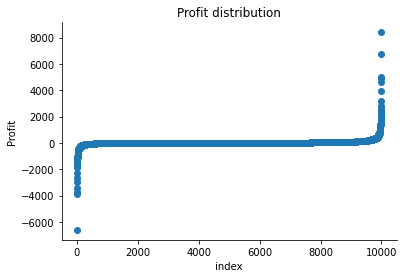

In [9]:
plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('index')
plt.ylabel('Profit')
plt.title("Profit distribution")
sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


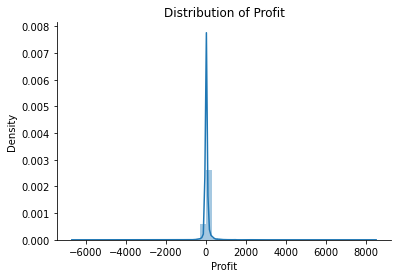

In [10]:
sns.distplot(df['Profit'])
plt.title("Distribution of Profit")
sns.despine()

In [11]:
print("Skewness: %f" % df['Profit'].skew())
print("Kurtosis: %f" % df['Profit'].kurt())

Skewness: 7.561432
Kurtosis: 397.188515


The Superstore’s Profit distribution has both a positive tail and negative tail. However, the positive tail is longer than the negative tail. So the distribution is positive skewed, and the data are heavy-tailed or profusion of outliers.
There are two regions where the data has low probability to appear: one on the right side of the distribution, another one on the left.

### Univariate Anomaly Detection on Sales

## Isolation Forest

Isolation Forest is an algorithm to detect outliers that returns the anomaly score of each sample using the IsolationForest algorithm which is based on the fact that anomalies are data points that are few and different. Isolation Forest is a tree-based model. In these trees, partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature.

The following process shows how IsolationForest behaves in the case of the Susperstore’s sales, and the algorithm is implemented in Sklearn:

* Trained IsolationForest using the Sales data.
* Store the Sales in the NumPy array for using in our models later.
* Computed the anomaly score for each observation. The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
* Classified each observation as an outlier or non-outlier.
* The visualization highlights the regions where the outliers fall.

In [12]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))
df['anomaly_score_univariate_sales'] = isolation_forest.decision_function(df['Sales'].values.reshape(-1, 1))
df['outlier_univariate_sales'] = isolation_forest.predict(df['Sales'].values.reshape(-1, 1))

In [13]:
df.sort_values('anomaly_score_univariate_sales')

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,anomaly_score_univariate_sales,outlier_univariate_sales
2697,2698,CA-2014-145317,2014-03-18,2014-03-23,Standard Class,SM-20320,Sean Miller,Home Office,United States,Jacksonville,...,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784,-0.118803,-1
6826,6827,CA-2016-118689,2016-10-02,2016-10-09,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.950,5,0.0,8399.9760,-0.118803,-1
8153,8154,CA-2017-140151,2017-03-23,2017-03-25,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,4,0.0,6719.9808,-0.115274,-1
2623,2624,CA-2017-127180,2017-10-22,2017-10-24,First Class,TA-21385,Tom Ashbrook,Home Office,United States,New York City,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,11199.968,4,0.2,3919.9888,-0.111759,-1
4190,4191,CA-2017-166709,2017-11-17,2017-11-22,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Newark,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,3,0.0,5039.9856,-0.111759,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,1354,CA-2017-162978,2017-05-04,2017-05-09,Standard Class,LW-16990,Lindsay Williams,Corporate,United States,San Francisco,...,OFF-PA-10002250,Office Supplies,Paper,Things To Do Today Pad,17.610,3,0.0,8.4528,0.368919,1
7383,7384,CA-2016-105732,2016-09-13,2016-09-18,Standard Class,AG-10270,Alejandro Grove,Consumer,United States,Omaha,...,OFF-PA-10002250,Office Supplies,Paper,Things To Do Today Pad,17.610,3,0.0,8.4528,0.368919,1
7385,7386,CA-2016-105732,2016-09-13,2016-09-18,Standard Class,AG-10270,Alejandro Grove,Consumer,United States,Omaha,...,OFF-PA-10001838,Office Supplies,Paper,Adams Telephone Message Book W/Dividers/Space ...,17.640,3,0.0,8.6436,0.368919,1
6775,6776,CA-2015-105361,2015-03-29,2015-04-04,Standard Class,CM-12115,Chad McGuire,Consumer,United States,New York City,...,OFF-PA-10002615,Office Supplies,Paper,"Ampad Gold Fibre Wirebound Steno Books, 6"" x 9...",17.640,4,0.0,8.1144,0.368919,1


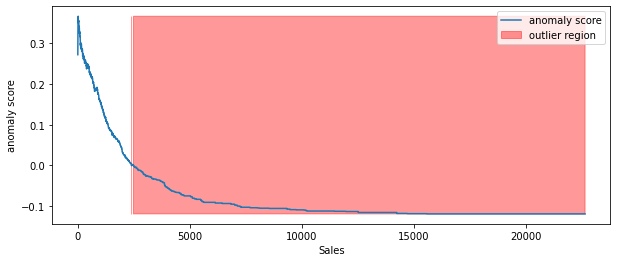

In [14]:
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show();

According to the above results and visualization, it seems that sales that exceeds 1500 would be definitely considered as an outlier.

### Anomaly detection on Profit

In [15]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))
df['anomaly_score_univariate_profit'] = isolation_forest.decision_function(df['Profit'].values.reshape(-1, 1))
df['outlier_univariate_profit'] = isolation_forest.predict(df['Profit'].values.reshape(-1, 1))

In [16]:
df.sort_values('anomaly_score_univariate_profit')

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,anomaly_score_univariate_sales,outlier_univariate_sales,anomaly_score_univariate_profit,outlier_univariate_profit
6826,6827,CA-2016-118689,2016-10-02,2016-10-09,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,...,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.950,5,0.0,8399.9760,-0.118803,-1,-0.085291,-1
8153,8154,CA-2017-140151,2017-03-23,2017-03-25,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,...,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,4,0.0,6719.9808,-0.115274,-1,-0.084715,-1
4190,4191,CA-2017-166709,2017-11-17,2017-11-22,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Newark,...,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,3,0.0,5039.9856,-0.111759,-1,-0.080120,-1
9039,9040,CA-2016-117121,2016-12-17,2016-12-21,Standard Class,AB-10105,Adrian Barton,Consumer,United States,Detroit,...,Binders,GBC Ibimaster 500 Manual ProClick Binding System,9892.740,13,0.0,4946.3700,-0.108841,-1,-0.080120,-1
4098,4099,CA-2014-116904,2014-09-23,2014-09-28,Standard Class,SC-20095,Sanjit Chand,Consumer,United States,Minneapolis,...,Binders,Ibico EPK-21 Electric Binding System,9449.950,5,0.0,4630.4755,-0.107095,-1,-0.078403,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,2658,CA-2017-112515,2017-09-17,2017-09-21,Second Class,AS-10225,Alan Schoenberger,Corporate,United States,Provo,...,Labels,Avery 514,14.400,5,0.0,7.0560,0.361692,1,0.442708,1
462,463,CA-2016-109869,2016-04-22,2016-04-29,Standard Class,TN-21040,Tanja Norvell,Home Office,United States,Phoenix,...,Furnishings,Eldon Wave Desk Accessories,23.560,5,0.2,7.0680,0.350993,1,0.442708,1
8490,8491,CA-2016-158841,2016-02-02,2016-02-04,Second Class,SE-20110,Sanjit Engle,Consumer,United States,Arlington,...,Furnishings,Acrylic Self-Standing Desk Frames,18.690,7,0.0,7.1022,0.366475,1,0.442708,1
7208,7209,CA-2016-143476,2016-09-11,2016-09-13,First Class,LC-16930,Linda Cazamias,Corporate,United States,Phoenix,...,Paper,Xerox 1976,20.736,4,0.2,7.2576,0.358368,1,0.442708,1


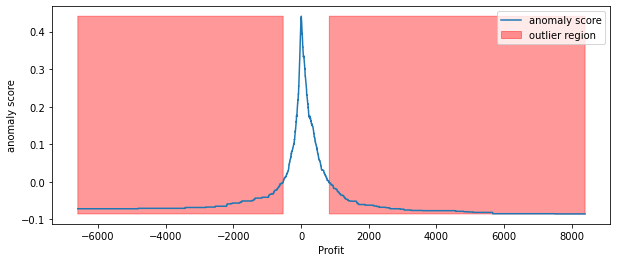

In [17]:
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Profit')
plt.show();

According to the above results and visualization, it seems Profit that is below -100 or exceeds 100 would be considered as an outlier.

In [18]:
df[(df['outlier_univariate_profit']==-1) & (df['outlier_univariate_sales']==-1)]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,anomaly_score_univariate_sales,outlier_univariate_sales,anomaly_score_univariate_profit,outlier_univariate_profit
27,28,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.430,7,0.5,-1665.0522,-0.025737,-1,-0.050850,-1
165,166,CA-2014-139892,2014-09-08,2014-09-12,Standard Class,BM-11140,Becky Martin,Consumer,United States,San Antonio,...,Machines,Lexmark MX611dhe Monochrome Laser Printer,8159.952,8,0.4,-1359.9920,-0.104773,-1,-0.044789,-1
318,319,CA-2014-164973,2014-11-04,2014-11-09,Standard Class,NM-18445,Nathan Mautz,Home Office,United States,New York City,...,Machines,Canon imageCLASS MF7460 Monochrome Digital Las...,3991.980,2,0.0,1995.9900,-0.054688,-1,-0.061986,-1
353,354,CA-2016-129714,2016-09-01,2016-09-03,First Class,AB-10060,Adam Bellavance,Home Office,United States,New York City,...,Binders,GBC DocuBind P400 Electric Binding System,4355.168,4,0.2,1415.4296,-0.065128,-1,-0.050297,-1
509,510,CA-2015-145352,2015-03-16,2015-03-22,Standard Class,CM-12385,Christopher Martinez,Consumer,United States,Atlanta,...,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,6354.950,5,0.0,3177.4750,-0.092110,-1,-0.074980,-1
515,516,CA-2017-127432,2017-01-22,2017-01-27,Standard Class,AD-10180,Alan Dominguez,Home Office,United States,Great Falls,...,Copiers,Canon Image Class D660 Copier,2999.950,5,0.0,1379.9770,-0.022585,-1,-0.048641,-1
683,684,US-2017-168116,2017-11-04,2017-11-04,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,...,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904,-0.103614,-1,-0.070437,-1
994,995,CA-2014-117639,2014-05-21,2014-05-25,Standard Class,MW-18235,Mitch Willingham,Corporate,United States,Virginia Beach,...,Binders,Fellowes PB300 Plastic Comb Binding Machine,2715.930,7,0.0,1276.4871,-0.011136,-1,-0.041502,-1
1085,1086,US-2016-143819,2016-03-01,2016-03-05,Standard Class,KD-16270,Karen Daniels,Consumer,United States,Yonkers,...,Machines,Ativa V4110MDD Micro-Cut Shredder,4899.930,7,0.0,2400.9657,-0.074584,-1,-0.067611,-1
1454,1455,CA-2016-133711,2016-11-26,2016-11-29,First Class,MC-17425,Mark Cousins,Corporate,United States,Mobile,...,Machines,Hewlett-Packard Deskjet 3050a All-in-One Color...,3040.000,8,0.0,1459.2000,-0.025211,-1,-0.050850,-1


The above two visualizations show the anomaly scores and highlighted the regions where the outliers are. As expected, the anomaly score reflects the shape of the underlying distribution and the outlier regions correspond to low probability areas.

However, univariate analysis can only get us thus far. We may realize that some of these anomalies that determined by our models are anomalous in context of one variable but not the other. When our data is multidimensional as opposed to univariate, the approaches to anomaly detection become more computationally intensive and more mathematically complex.

# Multivariate Anomaly Detection

Most of the analysis that we end up doing are multivariate due to complexity of the world we are living in. In multivariate anomaly detection, outlier is a combined unusual score on at least two variables.

So, using the Sales and Profit variables, we are going to build an unsupervised multivariate anomaly detection model.

### Sales & Profit

When we are in business, we expect that Sales & Profit are positive correlated. If some of the Sales data points and Profit data points are not positive correlated, they would be considered as outliers and need to be further investigated.

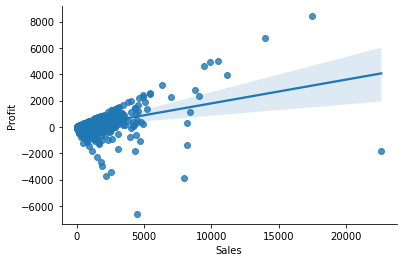

In [19]:
sns.regplot(x="Sales", y="Profit", data=df)
sns.despine();

From the above correlation chart, we can see that some of the data points are obvious outliers such as extreme low and extreme high values.

In [20]:
minmax = MinMaxScaler(feature_range=(0, 1))
X = minmax.fit_transform(df[['Sales','Profit']])

In [21]:
clf = IsolationForest(n_estimators=100, contamination=0.01, random_state=0)
clf.fit(X)

# predict raw anomaly score
df['multivariate_anomaly_score'] = clf.decision_function(X)
        
# prediction of a datapoint category outlier or inlier
df['multivariate_outlier'] = clf.predict(X)

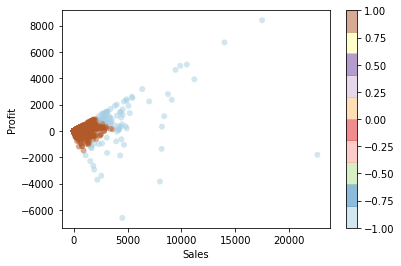

In [22]:
plt.scatter(df['Sales'], df['Profit'],
            c=df.multivariate_outlier, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Paired', 10))
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.colorbar();

In [23]:
df[(df['outlier_univariate_sales'] == 1) & (df['outlier_univariate_profit'] == 1) & (df['multivariate_outlier'] == -1)]


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,anomaly_score_univariate_sales,outlier_univariate_sales,anomaly_score_univariate_profit,outlier_univariate_profit,multivariate_anomaly_score,multivariate_outlier
1001,1002,CA-2015-124891,2015-07-31,2015-07-31,Same Day,RH-19495,Rick Hansen,Consumer,United States,New York City,...,2309.65,7,0.0,762.1845,0.008744,1,0.008802,1,-0.003494,-1
5530,5531,CA-2017-160885,2017-12-02,2017-12-06,Standard Class,JK-16090,Juliana Krohn,Consumer,United States,Omaha,...,2479.96,4,0.0,743.9880,0.000651,1,0.011872,1,-0.010036,-1
9948,9949,CA-2017-121559,2017-06-01,2017-06-03,Second Class,HW-14935,Helen Wasserman,Corporate,United States,Indianapolis,...,2405.20,8,0.0,793.7160,0.000651,1,0.003658,1,-0.009530,-1


### Visually investigate some of the anomalies

We may want to investigate each of the outliers that determined by our model and try to understand what make them anomalies.